## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 24 января 2025**

**Дедлайн: 8 февраля 2025 23:59 MSK**

In [215]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [2]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
719785,88120,4151,122,11027,100.0
2392255,1044005,12908,128,10451,100.0
56545,732150,13849,123,2453,44.0
4770184,858,11495,148,22597,60.0
5044153,801780,15297,112,30452,100.0


Сделаем разбиение по времени

<Axes: >

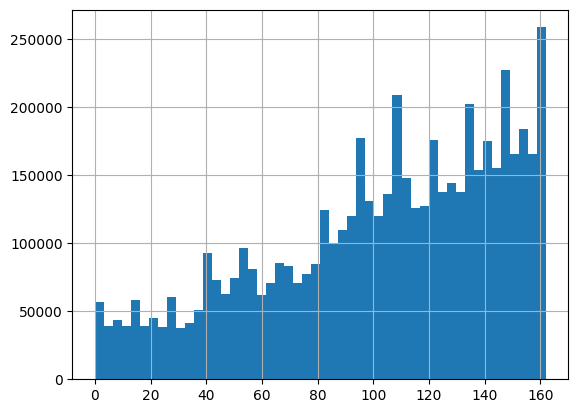

In [4]:
df.last_watch_dt.hist(bins=50)

In [5]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [6]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [7]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [8]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
47,163922,1931,45,155,0.0
87,379585,9070,151,2301,35.0
123,514235,8391,147,3570,57.0
209,14246,8447,94,4875,80.0
299,307436,13262,150,707,12.0


In [9]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

/tmp/ipython-input-1105526701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
/tmp/ipython-input-1105526701.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,157,"[(10440, 142), (15297, 143), (4713, 151), (124..."
1,164,"[(9728, 147), (10768, 148), (6431, 148), (1155..."
2,282,"[(5250, 45), (7626, 83), (12463, 106), (11348,..."
3,291,"[(6089, 145), (5507, 148), (10440, 148), (7019..."
4,654,"[(11237, 3), (6273, 4), (11936, 4), (14646, 4)..."


In [10]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]"
1,164,"[(9728, 147), (10768, 148), (6431, 148), (1155...","[(6192, 153), (9563, 153), (6950, 153), (805, ..."
2,282,"[(5250, 45), (7626, 83), (12463, 106), (11348,...","[(12841, 162), (8821, 162)]"
3,291,"[(6089, 145), (5507, 148), (10440, 148), (7019...","[(5576, 157)]"
4,654,"[(11237, 3), (6273, 4), (11936, 4), (14646, 4)...","[(1337, 153), (12192, 153), (984, 153), (341, ..."


In [11]:
np.random.seed(777)

class Random:
    def __init__(self):
        self.trained = False

    def fit(self, df, col='train_interactions'):
        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[8011, 12017, 280]"
1,164,"[(9728, 147), (10768, 148), (6431, 148), (1155...","[(6192, 153), (9563, 153), (6950, 153), (805, ...","[8011, 12017, 280]"
2,282,"[(5250, 45), (7626, 83), (12463, 106), (11348,...","[(12841, 162), (8821, 162)]","[8011, 12017, 280]"
3,291,"[(6089, 145), (5507, 148), (10440, 148), (7019...","[(5576, 157)]","[8011, 12017, 280]"
4,654,"[(11237, 3), (6273, 4), (11936, 4), (14646, 4)...","[(1337, 153), (12192, 153), (984, 153), (341, ...","[8011, 12017, 280]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [12]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if len(gt_items) == 0 or len(predictions) == 0:
        return 0.0

    if topn is None:
        topn = len(predictions)

    gt_set = set(gt_items)
    preds_k = predictions[:topn]

    r = np.array([p in gt_set for p in preds_k], dtype=float)
    if not np.any(r):
        return 0.0

    p = np.cumsum(r) / np.arange(1, len(r) + 1)

    return np.sum(r * p) / min(topn, len(gt_items))


def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if len(gt_items) == 0 or len(predictions) == 0:
        return 0.0

    if topn is None:
        topn = len(predictions)

    gt_set = set(gt_items)
    preds_k = predictions[:topn]
    r = np.array([p in gt_set for p in preds_k], dtype=bool)

    return 1.0 / (np.argmax(r) + 1) if np.any(r) else 0.0


def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if len(gt_items) == 0 or len(predictions) == 0:
        return 0.0

    if topn is None:
        topn = len(predictions)

    gt_set = set(gt_items)
    preds_k = predictions[:topn]

    r = np.array([p in gt_set for p in preds_k], dtype=bool)

    return float(np.any(r))

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит.

In [216]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать.

In [14]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):
    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [15]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': np.float64(0.00047222222222222213),
 'mrr': np.float64(0.0013),
 'hr': np.float64(0.0017)}

In [16]:
class TopPopular:
    def __init__(self):
        self.trained = False

    def fit(self, df, col='train_interactions'):
        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:
        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[8011, 12017, 280]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,164,"[(9728, 147), (10768, 148), (6431, 148), (1155...","[(6192, 153), (9563, 153), (6950, 153), (805, ...","[8011, 12017, 280]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,282,"[(5250, 45), (7626, 83), (12463, 106), (11348,...","[(12841, 162), (8821, 162)]","[8011, 12017, 280]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,291,"[(6089, 145), (5507, 148), (10440, 148), (7019...","[(5576, 157)]","[8011, 12017, 280]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,654,"[(11237, 3), (6273, 4), (11936, 4), (14646, 4)...","[(1337, 153), (12192, 153), (984, 153), (341, ...","[8011, 12017, 280]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [17]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': np.float64(0.06726327338435376),
 'mrr': np.float64(0.1206855158730159),
 'hr': np.float64(0.2794)}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [18]:
class TopPopularWeighted(TopPopular):
    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        flat_df = pd.DataFrame([it for row in df[col] for it in row], columns=['item_id', 'ts'])

        threshold = flat_df['ts'].max() - self.min_window
        self.recommenations = (
            flat_df[flat_df['ts'] >= threshold]['item_id']
            .value_counts()
            .index.tolist()
        )
        self.trained = True

        return self

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

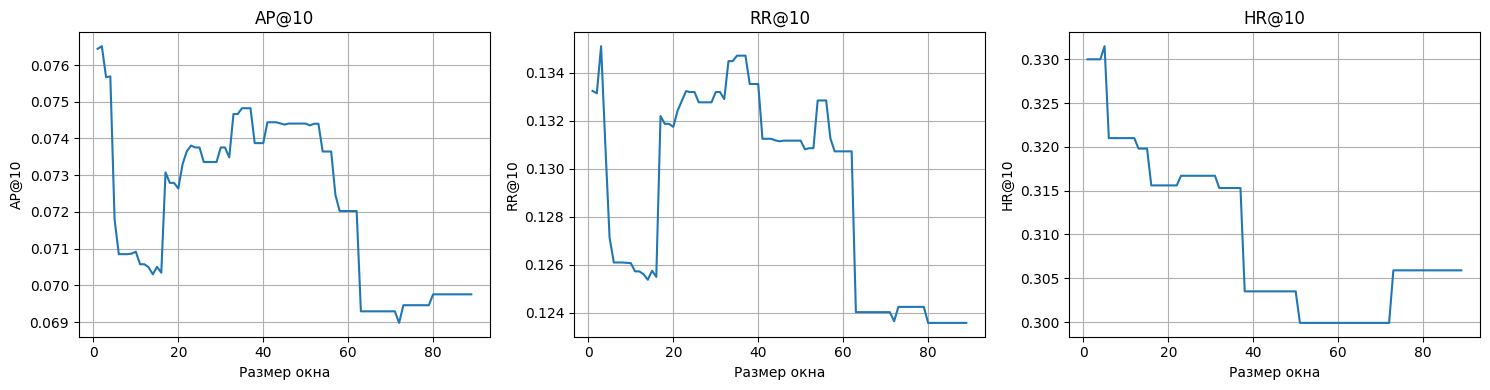

In [19]:
windows = range(1, 90)
metrics = {'map': [], 'mrr': [], 'hr': []}

for w in windows:
    model = TopPopularWeighted(min_window=w)
    model.fit(joined)

    top_10 = model.recommenations[:10]

    res = evaluate_recommender(
        joined.assign(temp_recs=[top_10] * len(joined)),
        'temp_recs'
    )

    for m in metrics:
        metrics[m].append(res.get(m, 0))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (m, lbl) in enumerate([('map', 'AP@10'), ('mrr', 'RR@10'), ('hr', 'HR@10')]):
    axes[i].plot(windows, metrics[m])
    axes[i].set_xlabel('Размер окна')
    axes[i].set_ylabel(lbl)
    axes[i].set_title(lbl)
    axes[i].grid()
plt.tight_layout()
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**

Окно 1-5 -> метрики на пике, данных достаточно для выявления самых свежих трендов и последних предпочтений юзеров     
Окно 6-18 -> провал AP@10, RR@10, модель начинает путаться между текущими хайповыми трендами и устаревающими популярными фильмами, качество снижается    
Окно 19-59 -> основной вклад теперь вносят скорее какие-то стабильно пользующиеся спросом фильмы/сериалы, но качество все равно ниже, чем если оперировать более свежими предпочтениями      
Окно 60+ -> метрики выходят на плато, событийные контексты разных периодов смешиваются, поэтому рекомендации становятся менее качественными, чем при более коротких окнах (но это можно было бы поисследовать еще и поиграться, например, с взвешиванием рекомендаций)

На мой взгляд, лучше всего подойдет окно ~3-5 дней, такое окно лучше и быстрее подхватывает новые коллективные тренды в фильмах и сериалах, да и делает топ интереснее, потому что так он, вероятно, будет чаще меняться и привлекать внимание  

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике.

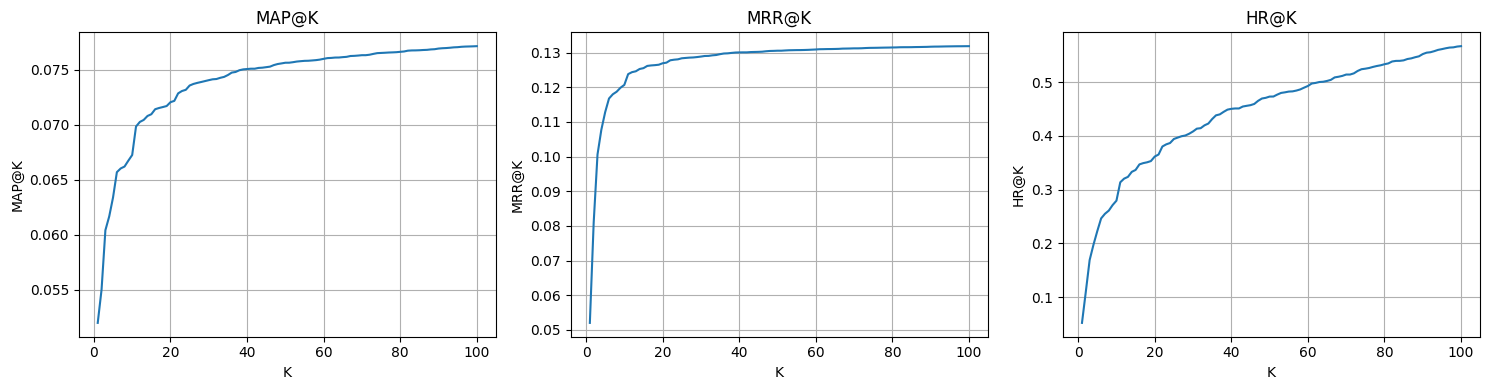

In [20]:
ks = range(1, 101)
metrics = {'map': [], 'mrr': [], 'hr': []}

joined['toppopular_recs'] = toppop.predict(joined, topn=100)

for k in ks:
    recs_k = joined['toppopular_recs'].apply(lambda r: r[:k])
    res = evaluate_recommender(
        joined.assign(toppop_k=recs_k),
        'toppop_k'
    )
    for m in metrics:
        metrics[m].append(res[m])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (m, lbl) in enumerate([('map', 'MAP@K'), ('mrr', 'MRR@K'), ('hr', 'HR@K')]):
    axes[i].plot(ks, metrics[m])
    axes[i].set_xlabel('K')
    axes[i].set_ylabel(lbl)
    axes[i].set_title(lbl)
    axes[i].grid()
plt.tight_layout()
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**  
Все три метрики. Мы просто добавляем новые фильмы в список, не удаляя старые  
HR@K: если угадали при K=5, то при K=10 или K=100 это попадание никуда не исчезнет   
MAP@K, MRR@K: добавление новых элементов в конец списка может либо не изменить метрику (нет нужных фильмов), либо увеличить её (среди новых позиций нашлось что-то полезное)  

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например, скроллингом ленты новостей. \
**Ответ:**  
MAP@K, MRR@K: эти метрики показывают, насколько ценны именно первые позиции в списке. По графикам видно, что они достаточно быстро выходят на плато. Это значит, что всё самое релевантное для пользователя сосредоточено на первых ~20 позициях  
HR@K: эта метрика про то, доскроллит ли пользователь до интересного фильма вообще. До K=20 видим активный рост => большинству зрителей первых ~20 позиций хватает, чтобы зацепиться за какой-то фильм. После 20 рост замедляется, но не останавливается, значит, есть категория "придирчивых" пользователей или тех, кто ищет что-то специфическое, они дольше листают ленту, чтобы найти подходящий вариант  

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**  
Должны возрастать, потому что при расширении выборки вероятность того, что в неё попадёт нужный фильм, только растёт. Резкий взлёт в начале объясняется Popularity Bias и законом Парето: большая часть аудитории смотрит один и тот же ограниченный список хитов, поэтому топовые позиции дают основной буст метрикам. А то, что графики продолжают более медленно, но расти, говорит о разнообразии вкусов юзеров - модель постепенно "добирает" пользователей с интересами из "длинного хвоста", т.е. менее популярных фильмов  

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [21]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

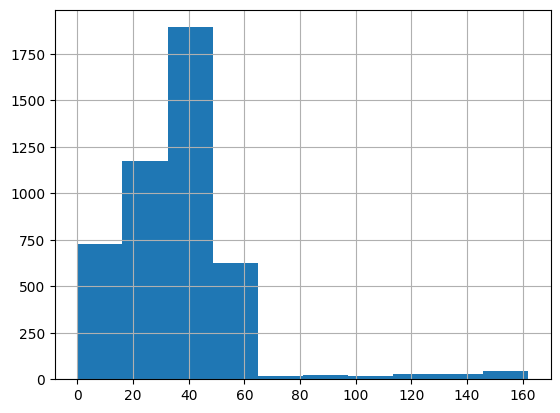

In [22]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

Можно взять 100 самых просматриваемых фильмов и рассчитать для них slope, cv и peak (тренд, стабильность, сила пиков) и отобрать фильмы по экстремумам метрик

In [23]:
results = []
for id in df.item_id.value_counts()[:100].index:
    data = df[df.item_id == id]
    dates = pd.to_datetime(data.last_watch_dt, unit='D', origin='1970-01-01').dt.date
    cnts = pd.Series(dates).value_counts().sort_index()

    slope = np.polyfit(np.arange(len(cnts)), cnts, 1)[0]
    peak = cnts.max() / cnts.mean()
    cv = cnts.std() / cnts.mean()
    title = items.loc[items.item_id == id, 'title'].values[0]

    results.append({'id': id, 'title': title, 'slope': slope, 'peak': peak, 'cv': cv})

patterns = pd.DataFrame(results)
samples = pd.concat([
    patterns.nsmallest(1, 'cv'),
    patterns.nlargest(1, 'slope'),
    patterns.nsmallest(1, 'slope'),
    patterns.nlargest(1, 'peak'),
    patterns.nlargest(1, 'cv')
])
print(samples.round(2))

       id         title   slope   peak    cv
10  12192  Фемида видит    1.26   1.53  0.28
24   7793  Радиовспышка   20.59   2.94  1.08
57  12360       Круэлла -214.16   2.98  0.94
0   10440   Хрустальный   16.72  16.07  1.53
72  14488   Мастер меча   18.58  10.36  2.67


Фемида видит


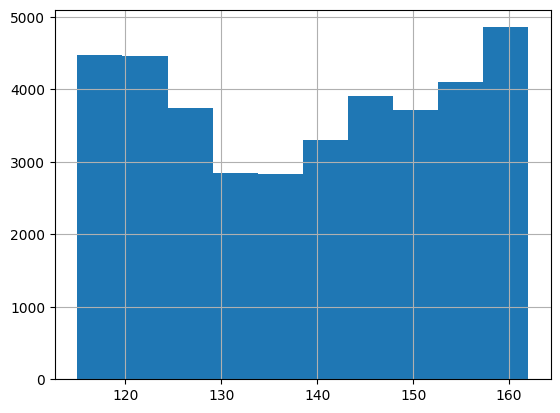

Радиовспышка


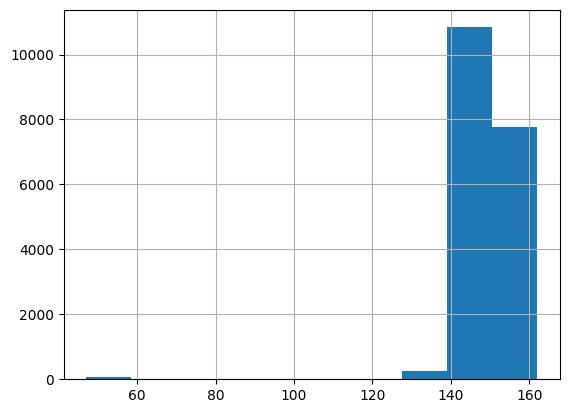

Круэлла


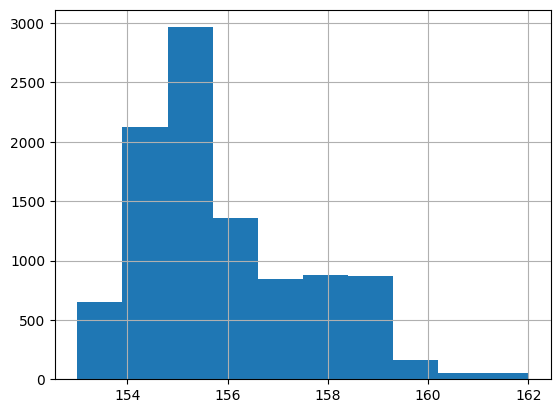

Хрустальный


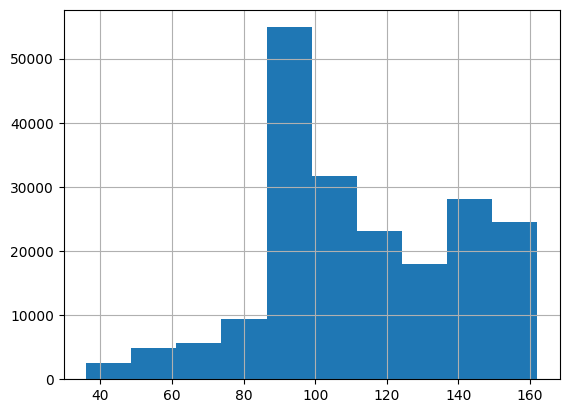

Мастер меча


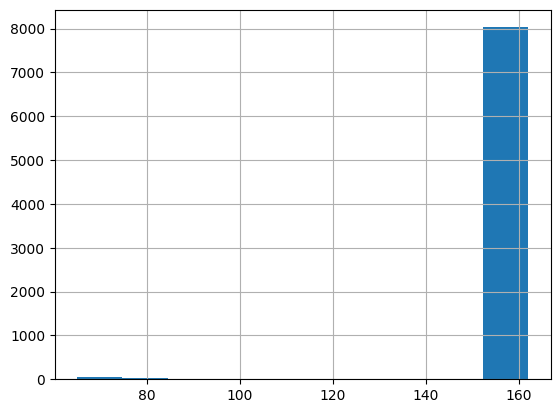

In [24]:
for sampled_id in samples.id:
    interactions = df.loc[df.item_id==sampled_id].copy()
    name = items.loc[items.item_id==sampled_id].title.values[0]
    print(name)
    interactions.last_watch_dt.hist()
    plt.show()

Фемида видит: устойчивый спрос без значительных колебаний, стабильный интерес; скорее всего, фильм имеет свою верную аудиторию  

Радиовспышка: резкий рост популярности; скорее всего, новый релиз

Круэлла: пик и угасающий интерес после; скорее всего, пик после премьеры и закономерно угасающий интерес после нее - основная аудитория посмотрела  

Хрустальный: разовый пик на фоне спокойного спроса; скорее всего, спровоцировано выходом какой-то отдельной провокационной серии и т.д.

Мастер меча: практически полное отсутствие интереса, прерываемое скачком популярности; скорее всего, скачок вызван внешним триггером (упоминанием в популярном посте и т.д.)

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [211]:
def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    u_cnt = df['user_id'].value_counts()
    i_cnt = df['item_id'].value_counts()

    valid_users = u_cnt[u_cnt >= min_freq].index
    valid_items = i_cnt[i_cnt >= min_freq].index

    df_f = df[df['user_id'].isin(valid_users) & df['item_id'].isin(valid_items)]

    return df_f

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    df_c = df.copy()

    while True:
        n_start = len(df_c)
        df_c = filter_column(df_c, min_freq)
        if len(df_c) == n_start:
            break

    return df_c

filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=5)

In [212]:
item2id = {id: idx for idx, id in enumerate(filtered_train['item_id'].unique())}
user2id = {id: idx for idx, id in enumerate(filtered_train['user_id'].unique())}
id2item = {idx: id for id, idx in item2id.items()}

In [213]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(len(filtered_train)),
     (filtered_train['user_id'].map(user2id), filtered_train['item_id'].map(item2id))),
    shape=(len(user2id), len(item2id))
).tocsr()

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра.

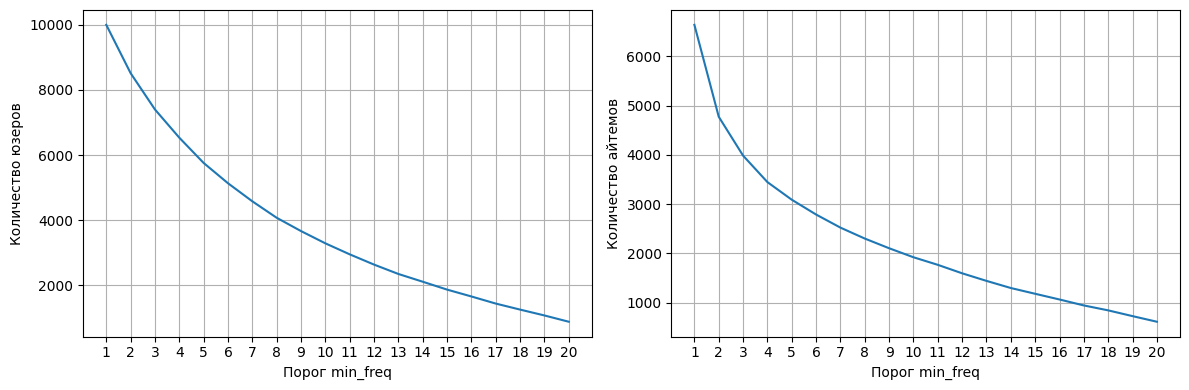

In [214]:
min_freqs = range(1, 21)
results = []
for mf in min_freqs:
    filtered = filter_dataframe(train_df, ['user_id', 'item_id'], mf)
    results.append((filtered.user_id.nunique(), filtered.item_id.nunique()))
n_users, n_items = zip(*results)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plots_info = [
    (n_users, 'Количество юзеров'),
    (n_items, 'Количество айтемов')
]
for i, (data, ylabel) in enumerate(plots_info):
    axes[i].plot(min_freqs, data)
    axes[i].set_xticks(min_freqs)
    axes[i].set_xlabel('Порог min_freq')
    axes[i].set_ylabel(ylabel)
    axes[i].grid()
plt.tight_layout()
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k.

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [46]:
%%time

def fit_ease(X, reg_weight=500):
    G = X.T @ X
    G += reg_weight * sps.identity(G.shape[0])
    G = G.todense()
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    np.fill_diagonal(B, 0.)
    return B

w = fit_ease(matrix)

CPU times: user 4.96 s, sys: 214 ms, total: 5.17 s
Wall time: 5.33 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [47]:
def get_preds(x, item2id, id2item, w, topk=100):
    watched_items = [t[0] for t in x if t[0] in item2id]

    if not watched_items:
        return []

    indices = [item2id[item] for item in watched_items]

    v = np.zeros(len(item2id))
    v[indices] = 1.0

    scores = np.asarray(v @ w).reshape(-1)
    scores[indices] = -np.inf

    best_indices = np.argsort(-scores)[:topk]

    return [id2item[idx] for idx in best_indices]

tqdm.pandas(desc="EASE")
joined['ease_preds'] = joined.train_interactions.progress_apply(lambda x: get_preds(x, item2id, id2item, w))
joined.head()

EASE:   0%|          | 0/10000 [00:00<?, ?it/s]

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,ease_preds
0,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[8011, 12017, 280]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[4151, 13865, 9728, 2657, 142, 12192, 3734, 99..."
1,164,"[(9728, 147), (10768, 148), (6431, 148), (1155...","[(6192, 153), (9563, 153), (6950, 153), (805, ...","[8011, 12017, 280]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[13865, 10440, 15297, 3734, 7829, 4436, 1844, ..."
2,282,"[(5250, 45), (7626, 83), (12463, 106), (11348,...","[(12841, 162), (8821, 162)]","[8011, 12017, 280]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[12173, 12057, 1553, 14317, 14264, 682, 12623,..."
3,291,"[(6089, 145), (5507, 148), (10440, 148), (7019...","[(5576, 157)]","[8011, 12017, 280]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[13865, 15297, 3734, 2657, 9996, 7829, 4151, 6..."
4,654,"[(11237, 3), (6273, 4), (11936, 4), (14646, 4)...","[(1337, 153), (12192, 153), (984, 153), (341, ...","[8011, 12017, 280]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[15297, 10440, 3734, 14703, 9996, 4495, 8636, ..."


In [48]:
print("EASE: ", evaluate_recommender(joined, 'ease_preds'))
print("TopPop: ", evaluate_recommender(joined, 'toppopular_recs'))

EASE:  {'map': np.float64(0.09598766562407476), 'mrr': np.float64(0.16780020906719714), 'hr': np.float64(0.6129)}
TopPop:  {'map': np.float64(0.07715763662874933), 'mrr': np.float64(0.1318637944016627), 'hr': np.float64(0.5669)}


Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**

EASE чаще находит релевантный контент, в его рекомендациях целевые фильмы поднялись выше - пользователь быстрее находит для себя что-то интересное, при этом весь топ строится точнее

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

In [52]:
regs = np.logspace(1, 6, 25)
results = {'map': [], 'mrr': [], 'hr': []}

for rw in tqdm(regs, desc="Lambda Search"):
    w_trial = fit_ease(matrix, reg_weight=rw)
    tmp_preds = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w_trial))
    metrics = evaluate_recommender(joined.assign(preds=tmp_preds), 'preds')
    for m in results:
        results[m].append(metrics[m])

best_map = max(results['map'])
best_reg = regs[np.argmax(results['map'])]
print(f"best_map={best_map:.4f}, best_reg={best_reg:.2f}")

Lambda Search:   0%|          | 0/25 [00:00<?, ?it/s]

best_map=0.1002, best_reg=5108.97


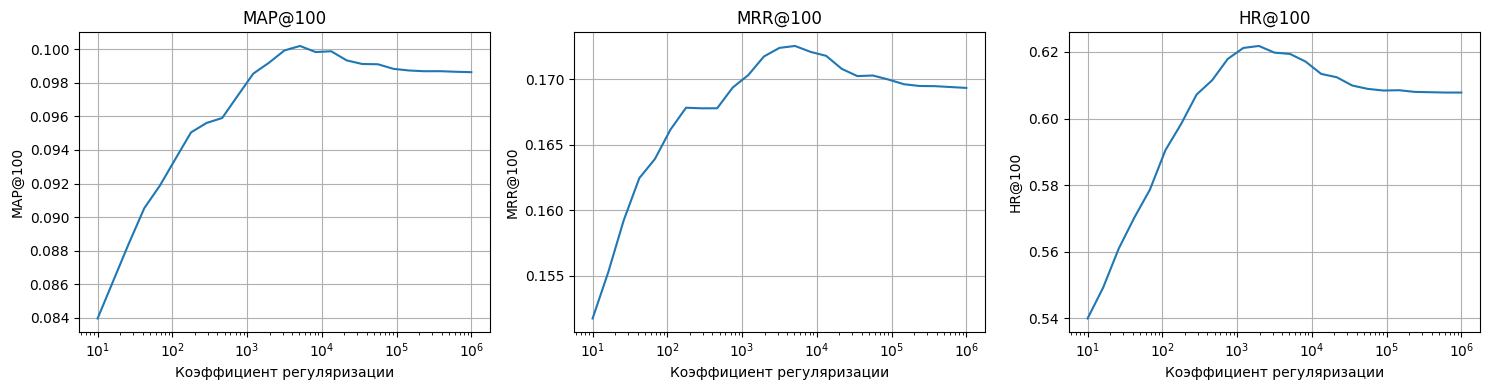

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (m, lbl) in enumerate([('map', 'MAP@100'), ('mrr', 'MRR@100'), ('hr', 'HR@100')]):
    axes[i].plot(regs, results[m])
    axes[i].set_xscale('log')
    axes[i].set_xlabel('Коэффициент регуляризации')
    axes[i].set_ylabel(lbl)
    axes[i].set_title(lbl)
    axes[i].grid()
plt.tight_layout()
plt.show()

In [54]:
w = fit_ease(matrix, reg_weight=5108.97)
joined['ease_preds'] = joined.train_interactions.progress_apply(lambda x: get_preds(x, item2id, id2item, w))
print("EASE: ", evaluate_recommender(joined, 'ease_preds'))

EASE:   0%|          | 0/10000 [00:00<?, ?it/s]

EASE:  {'map': np.float64(0.10020467682038199), 'mrr': np.float64(0.1725502501972261), 'hr': np.float64(0.6194)}


Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?

**Ответ:**

Что-то около 5000, так как пики метрик приходятся на интервал между 10^3 и 10^4; по перебору 5108.97

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:**

При маленьком коэффициенте метрики показывают самые низкие результаты, при очень большом выходят на плато, при этом есть стабильная зона ~2000-8000, где качество меняется не сильно. Все три метрики ведут себя практически идентично. При "плохих" коэффициентах просто хуже различается полезный сигнал и шум  

Что касается скорости тюнинга, относительно нейросетей подбор происходит быстро, потому что требуется лишь пересчитать формулу


**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

In [69]:
freq_thresholds = [5, 13, 21]
ks = range(1, 101, 5)
results = {f: {'map': [], 'mrr': [], 'hr': []} for f in freq_thresholds}

for mf in freq_thresholds:
    curr_train = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=mf)

    i2id = {id: idx for idx, id in enumerate(curr_train['item_id'].unique())}
    id2i = {idx: id for id, idx in i2id.items()}
    u2id = {id: idx for idx, id in enumerate(curr_train['user_id'].unique())}

    mat = sps.coo_matrix(
        (np.ones(len(curr_train)), (curr_train['user_id'].map(u2id), curr_train['item_id'].map(i2id))),
        shape=(len(u2id), len(i2id))
    ).tocsr()

    w_mf = fit_ease(mat, reg_weight=5108.97)

    temp_joined = joined[joined.user_id.isin(u2id.keys())].copy()
    temp_joined['max_preds'] = temp_joined.train_interactions.apply(
        lambda x: get_preds(x, i2id, id2i, w_mf, topk=100)
    )

    for k in ks:
        eval_res = evaluate_recommender(
            temp_joined.assign(k_preds=lambda x: x['max_preds'].apply(lambda r: r[:k])),
            'k_preds'
        )
        for m in ['map', 'mrr', 'hr']:
            results[mf][m].append(eval_res[m])

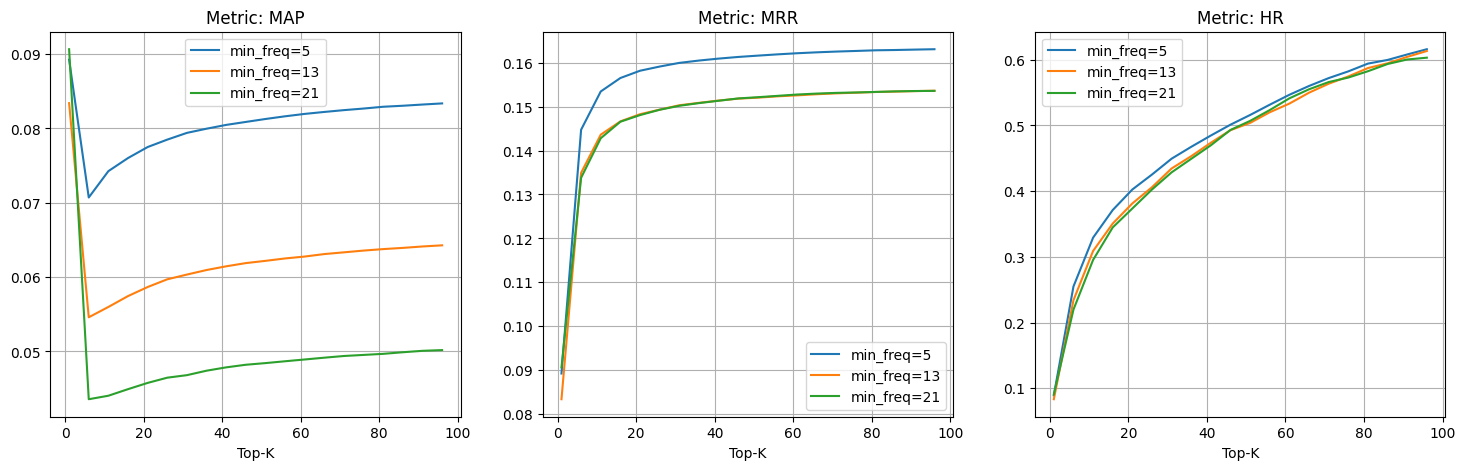

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, m in enumerate(['map', 'mrr', 'hr']):
    for mf in freq_thresholds:
        axes[i].plot(ks, results[mf][m], label=f'min_freq={mf}')
    axes[i].set_title(f'Metric: {m.upper()}')
    axes[i].set_xlabel('Top-K')
    axes[i].legend()
    axes[i].grid()
plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**  

Лучший результат у min_freq=5, худший у min_freq=21 => чем меньше фильтруем айтемы, тем выше итоговое качество   
То есть EASE лучше обучается на полных данных, так как даже редкие взаимодействия помогают модели точнее находить связи, что соответствует ожиданиям  

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.

In [92]:
def get_recs(search_str):
    hp_ids = items[items.title.str.contains(search_str, case=False)].item_id.values
    for i_id in hp_ids:
        if i_id in item2id:
            idx = item2id[i_id]
            title = items.loc[items.item_id == i_id, 'title'].values[0]
            best = np.argsort(-np.array(w[idx]).flatten())[:5]
            recs = [items.loc[items.item_id == id2item[i], 'title'].values[0] for i in best]
            print(f'Рекомендации к "{title}":')
            for i, r in enumerate(recs, 1):
                print(f'{i}. {r}')
            print()

In [93]:
get_recs("Наруто")

Рекомендации к "Наруто 8: Кровавая тюрьма":
1. Наруто 7: Потерянная башня
2. Наруто 9: Путь ниндзя
3. Наруто: Последний фильм
4. Тачки 3
5. Холодное сердце II

Рекомендации к "Наруто 7: Потерянная башня":
1. Наруто: Последний фильм
2. Наруто 9: Путь ниндзя
3. Наруто 8: Кровавая тюрьма
4. Девятаев
5. Афера

Рекомендации к "Наруто 9: Путь ниндзя":
1. Наруто: Последний фильм
2. Наруто 7: Потерянная башня
3. Наруто 8: Кровавая тюрьма
4. Мстители: Финал
5. Девятаев

Рекомендации к "Наруто: Последний фильм":
1. Наруто 9: Путь ниндзя
2. Наруто 7: Потерянная башня
3. Девятаев
4. Гнев человеческий
5. 100% волк



С Наруто рекомендуется в основном Наруто, причем другие части Наруто занимают именно первые позиции, логично  
Есть какие-то взрослые фильмы, вероятно, из-за того, что часто встречаются в истории просмотров

In [94]:
get_recs("Пираты карибского моря")

Рекомендации к "Пираты карибского моря: На странных берегах":
1. Пираты карибского моря: На краю света
2. Пираты Карибского моря: Мертвецы не рассказывают сказки
3. Пираты карибского моря: Проклятие чёрной жемчужины
4. Пираты Карибского Моря: Сундук Мертвеца
5. Гнев человеческий

Рекомендации к "Пираты Карибского моря: Мертвецы не рассказывают сказки":
1. Пираты карибского моря: На странных берегах
2. Пираты карибского моря: На краю света
3. Пираты карибского моря: Проклятие чёрной жемчужины
4. Пираты Карибского Моря: Сундук Мертвеца
5. Гнев человеческий

Рекомендации к "Пираты карибского моря: Проклятие чёрной жемчужины":
1. Пираты Карибского Моря: Сундук Мертвеца
2. Пираты карибского моря: На краю света
3. Пираты карибского моря: На странных берегах
4. Пираты Карибского моря: Мертвецы не рассказывают сказки
5. Гнев человеческий

Рекомендации к "Пираты карибского моря: На краю света":
1. Пираты карибского моря: Проклятие чёрной жемчужины
2. Пираты карибского моря: На странных берегах


С пиратами также

In [97]:
get_recs("Корпорация монстров")

Рекомендации к "Корпорация монстров":
1. Университет монстров
2. Зверополис
3. Ральф против Интернета
4. Рататуй
5. Монстры на каникулах 3: Море зовёт



Логично к мультику рекомендовать мультики, причем прежде всего другую часть той же вселенной

In [137]:
get_recs("Отчаянные домохозяйки")

Рекомендации к "Отчаянные домохозяйки":
1. Клиника счастья
2. Секреты семейной жизни
3. Хрустальный
4. Прабабушка легкого поведения
5. Гнев человеческий



В основном женские драмы, как и исходный сериал. 3 и 5 появились, видимо, из-за общей популярности у зрителей

In [155]:
get_recs("Бегущий по лезвию 2049")

Рекомендации к "Бегущий по лезвию 2049":
1. Гнев человеческий
2. Хрустальный
3. Девятаев
4. 2067: Петля времени
5. Алита: Боевой ангел



Более-менее в тему фильмы на 4 и 5 позиции. Вероятно, sci-fi не конек платформы, а бегущего по лезвию мало кто смотрел. А зря - там Райан Гослинг 🤙

In [180]:
get_recs("Ла-ла ленд")

Рекомендации к "Ла-ла ленд":
1. Гнев человеческий
2. Клиника счастья
3. Остров проклятых
4. Бегущий по лезвию 2049
5. Дьявол носит Prada



Видимо, мюзикл также не попадает в основную аудиторию сервиса

In [194]:
get_recs("До встречи с тобой")

Рекомендации к "До встречи с тобой":
1. Клиника счастья
2. Три метра над уровнем неба
3. Игра престолов
4. Два сердца
5. Один дома



Нормально, в основном женская ниша. Игра престолов, возможно, из-за фанатов Эмилии Кларк

In [206]:
get_recs("Бездомный Бог")

Рекомендации к "Бездомный Бог":
1. Укрась прощальное утро цветами обещания
2. 100% волк
3. Меморист
4. Клиника счастья
5. Прабабушка легкого поведения



Только на первой позиции порекомендовал аниме, все остальное мимо. Ожидаемо, аниме - нишевый жанр

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**  

Хорошие примеры есть: рекомендации получились удачными для массового контента, который и смотрит основная аудитория сервиса (много данных -> четкие связи)  
Есть и плохие примеры: для нишевого контента, который интересен сравнительно небольшому числу зрителей (мало данных -> более случайные связи)